In [2]:
import pandas as pd
# Common imports
import numpy as np
import os
import sklearn
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,\
                            roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### CARGAR LOS DATOS

In [20]:
df = pd.read_csv(r'C:\Users\iauzm\OneDrive\Desktop\DATA SCIENCE\AUZMENDI\PROYECTO-ML\modelos\tabla_pred_2',index_col='Unnamed: 0')
print(df.shape)
df.head()

(1187, 19)


,pts,FGM,FG_PCT,FG3M,FG3_PCT,REB,STL,BLK,PLUS_MINUS,INS,OUT,bpi,off,def,pbpi,OVR,DEF,TIER,target
0,-1.0,-1.0,0.014,-1.0,0.012,-16.0,0.0,-3.0,-16.0,8,-5,0.123,0.570,-0.446,0.123,0,3,1,1
1,14.0,2.0,0.054,0.0,-0.047,-5.0,2.0,-10.0,7.0,-8,5,2.395,1.483,0.913,2.395,1,-2,0,0
2,-10.0,-1.0,-0.081,-2.0,-0.092,-5.0,4.0,2.0,-19.0,2,-10,-2.005,-1.804,-0.201,-2.005,-1,-2,0,0
3,33.0,14.0,0.112,-1.0,-0.039,14.0,2.0,2.0,23.0,-1,1,-1.794,-1.973,0.179,-1.794,-2,-5,-1,1
4,-17.0,-4.0,-0.087,-8.0,-0.227,17.0,0.0,3.0,5.0,-1,-1,0.119,1.088,-0.969,0.119,1,8,0,1


### MINI EDA

In [5]:
def data_report(df):
    # Sacamos los NOMBRES
    cols = pd.DataFrame(df.columns.values, columns=["COL_N"])

    # Sacamos los TIPOS
    types = pd.DataFrame(df.dtypes.values, columns=["DATA_TYPE"])

    # Sacamos los MISSINGS
    percent_missing = round(df.isnull().sum() * 100 / len(df), 2)
    percent_missing_df = pd.DataFrame(percent_missing.values, columns=["MISSINGS (%)"])

    # Sacamos los VALORES UNICOS
    unicos = pd.DataFrame(df.nunique().values, columns=["UNIQUE_VALUES"])
    
    percent_cardin = round(unicos['UNIQUE_VALUES']*100/len(df), 2)
    percent_cardin_df = pd.DataFrame(percent_cardin.values, columns=["CARDIN (%)"])

    concatenado = pd.concat([cols, types, percent_missing_df, unicos, percent_cardin_df], axis=1, sort=False)
    concatenado.set_index('COL_N', drop=True, inplace=True)


    return concatenado.T
        
data_report(df)

COL_N,pts,FGM,FG_PCT,FG3M,FG3_PCT,REB,STL,BLK,PLUS_MINUS,INS,OUT,bpi,off,def,pbpi,OVR,DEF,TIER,target
DATA_TYPE,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64
MISSINGS (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UNIQUE_VALUES,316,190,771,168,847,221,117,114,418,53,33,797,787,795,797,15,23,5,2
CARDIN (%),26.62,16.01,64.95,14.15,71.36,18.62,9.86,9.6,35.21,4.47,2.78,67.14,66.3,66.98,67.14,1.26,1.94,0.42,0.17


### DIVIDIR EN TRAIN Y TEST

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1),
                                                    df['target'],
                                                    test_size=0.2,
                                                    random_state=42)

In [36]:
X_train.shape
X_test.shape

(238, 9)

### ESCALADO


In [32]:
# Ejemplo de código para un StandardScaler
from sklearn.preprocessing import StandardScaler

# Almaceno en el objeto scaler todo lo necesario para estandarizar, con los datos de train
scaler = StandardScaler()
scaler.fit(X_train)

# Utilizo los datos de train para escalar train y test.
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### COMPROBAR LA DISTRIBUCIÓN DE LOS DATOS

Aparentemente casi todas las feature siguen una distribución bastante normal. 

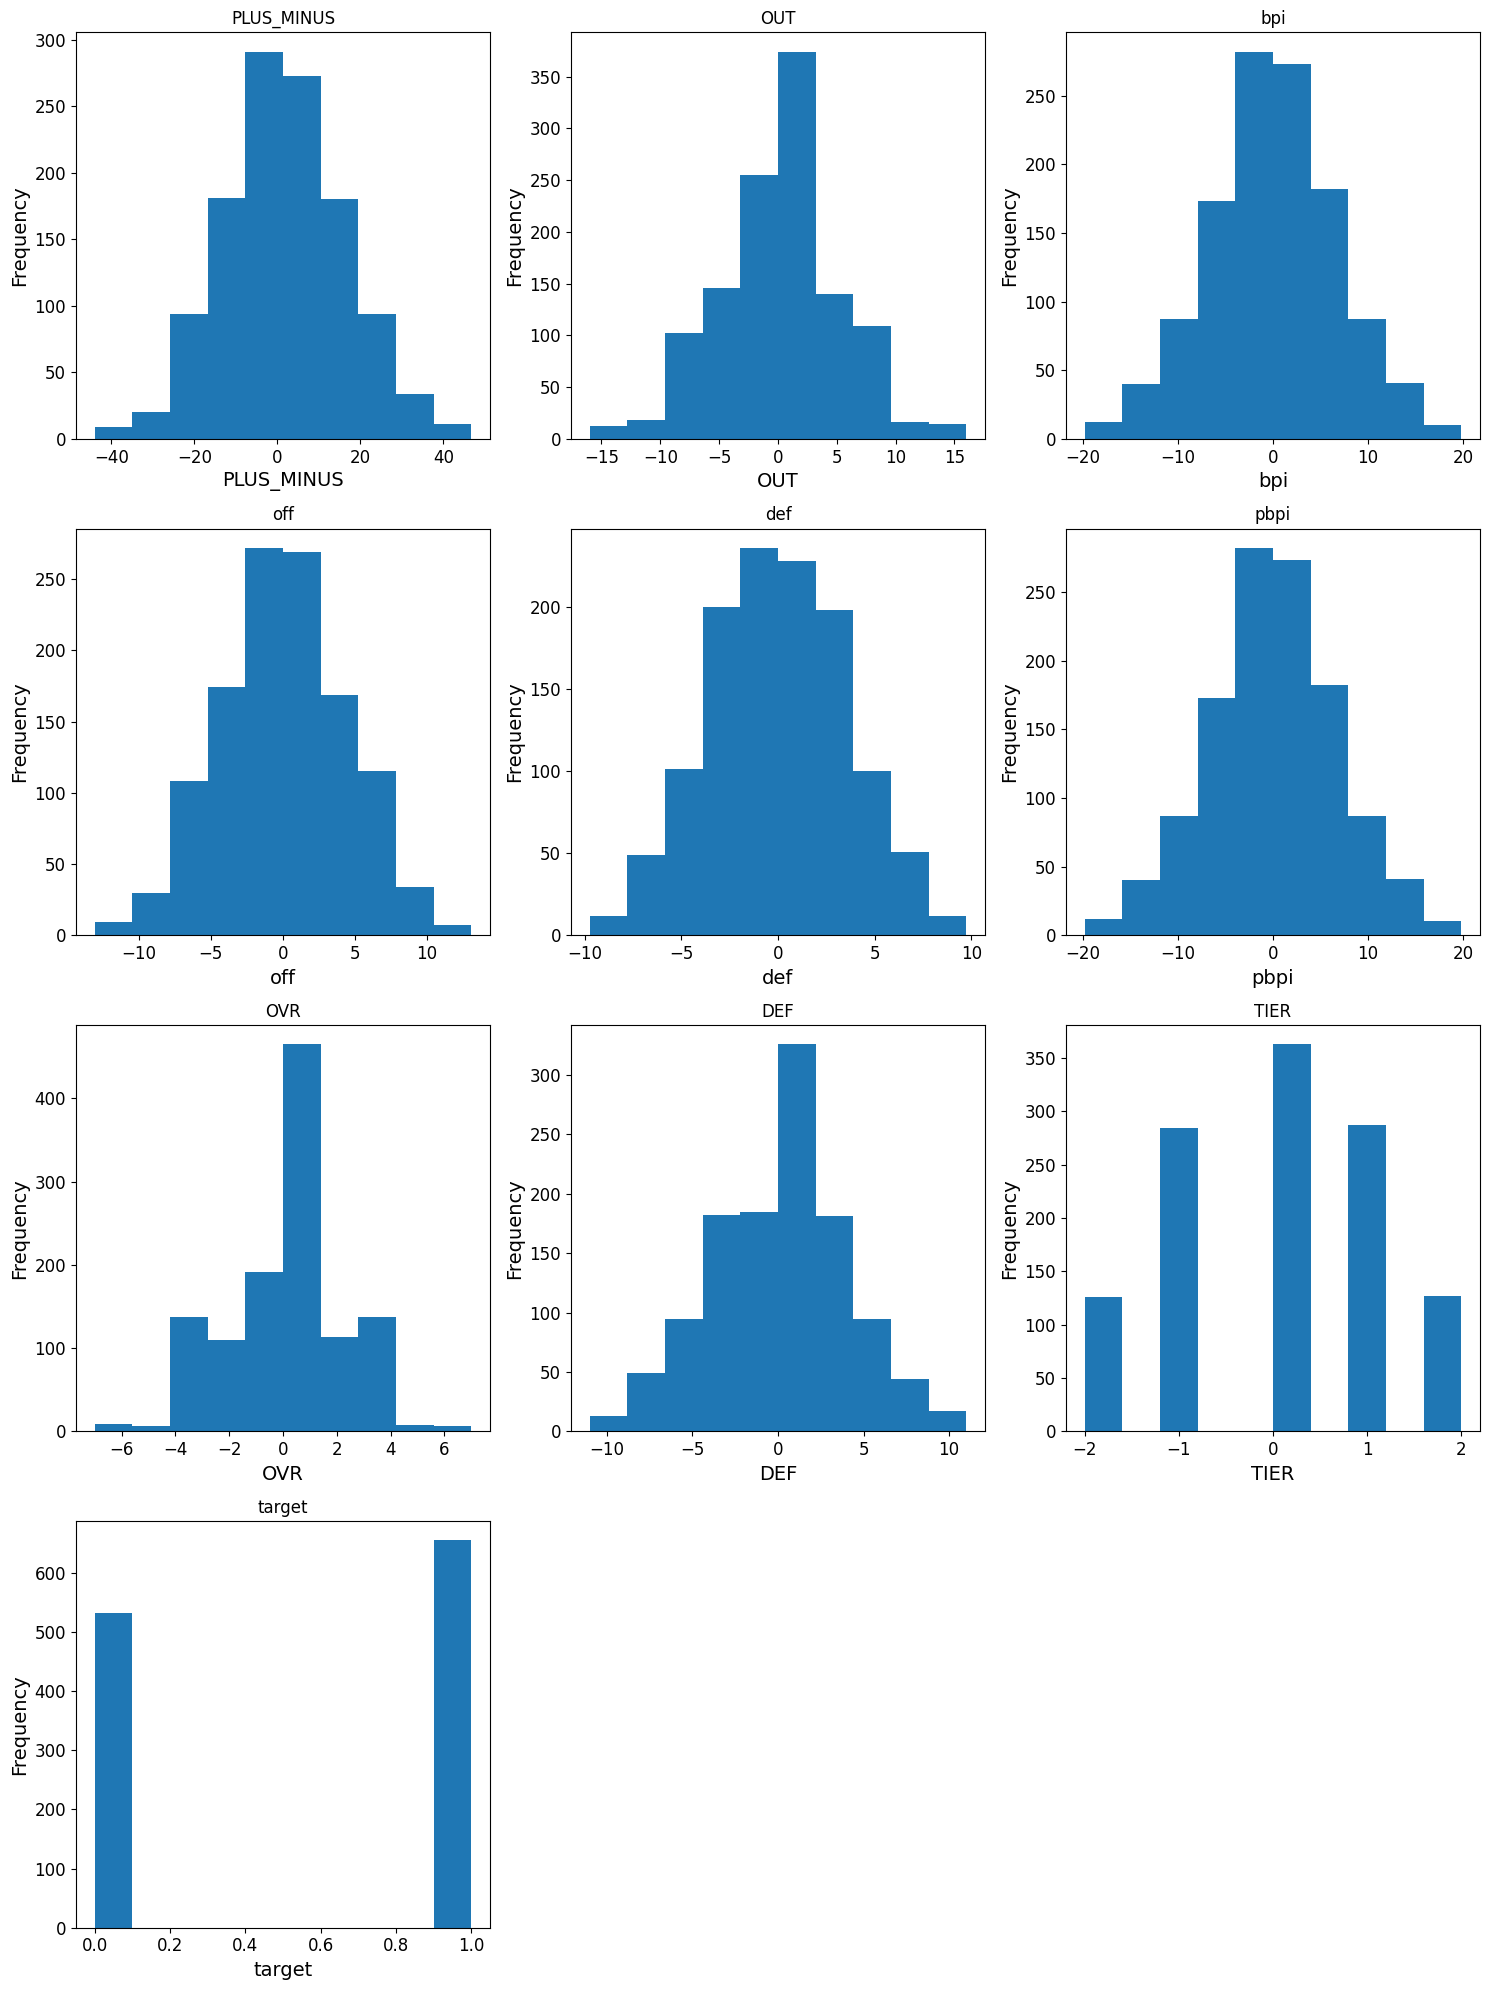

In [33]:
num_columns = len(df.columns)
num_rows = (num_columns // 3) + (num_columns % 3 > 0)  # Número de filas necesarias

fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))

# Aplanar el array de ejes para facilitar la iteración
axes = axes.flatten()

for i, col in enumerate(df.columns):
    df[col].plot(kind='hist', ax=axes[i], title=col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Eliminar ejes vacíos si los hay
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar el layout para que los títulos no se superpongan
plt.tight_layout()

# Mostrar el plot
plt.show()

In [40]:
from scipy.stats import shapiro

# Supongamos que ya tienes un DataFrame llamado df
# df = pd.DataFrame(...)

# Aplicar el test de Shapiro-Wilk a todas las columnas
results = {}
for col in df.columns:
    stat, p_value = shapiro(df[col])
    results[col] = {'Statistic': stat, 'p-value': p_value}

# Convertir los resultados a un DataFrame para mejor visualización
saphiro_df = pd.DataFrame(results).T

# Mostrar los resultados
print(saphiro_df)
#COMPRUEBO EN QUÉ COLUMNAS RECHAZAMOS LA HIPÓTESIS NULA. 
saphiro_df[saphiro_df['p-value']<0.05][:-2]


            Statistic       p-value
PLUS_MINUS   0.998846  6.561443e-01
OUT          0.994338  1.829021e-04
bpi          0.998627  4.876015e-01
off          0.998112  2.047641e-01
def          0.997348  4.720241e-02
pbpi         0.998627  4.876015e-01
OVR          0.978516  2.815884e-12
DEF          0.990802  9.058360e-07
TIER         0.917321  5.966428e-25
target       0.632683  1.225548e-44


,Statistic,p-value
OUT,0.994338,1.829021e-04
def,0.997348,4.720241e-02
OVR,0.978516,2.815884e-12
DEF,0.990802,9.058360e-07


#### Correlación lineal

In [35]:
df_1 = pd.DataFrame(df.iloc[:, :-1],columns= df.columns[:-1])

# Borra las columnas con una correlacion menor a 0.2
corr = np.abs(df.corr()['target']).sort_values(ascending=True)
print(corr)

bad_corr_feat = corr[corr <0.2].index.values
print(bad_corr_feat)

df.drop(columns = bad_corr_feat, inplace = True)

PLUS_MINUS    0.202827
DEF           0.232811
OUT           0.271829
TIER          0.283472
def           0.294674
OVR           0.387531
off           0.387866
bpi           0.411523
pbpi          0.411523
target        1.000000
Name: target, dtype: float64
[]


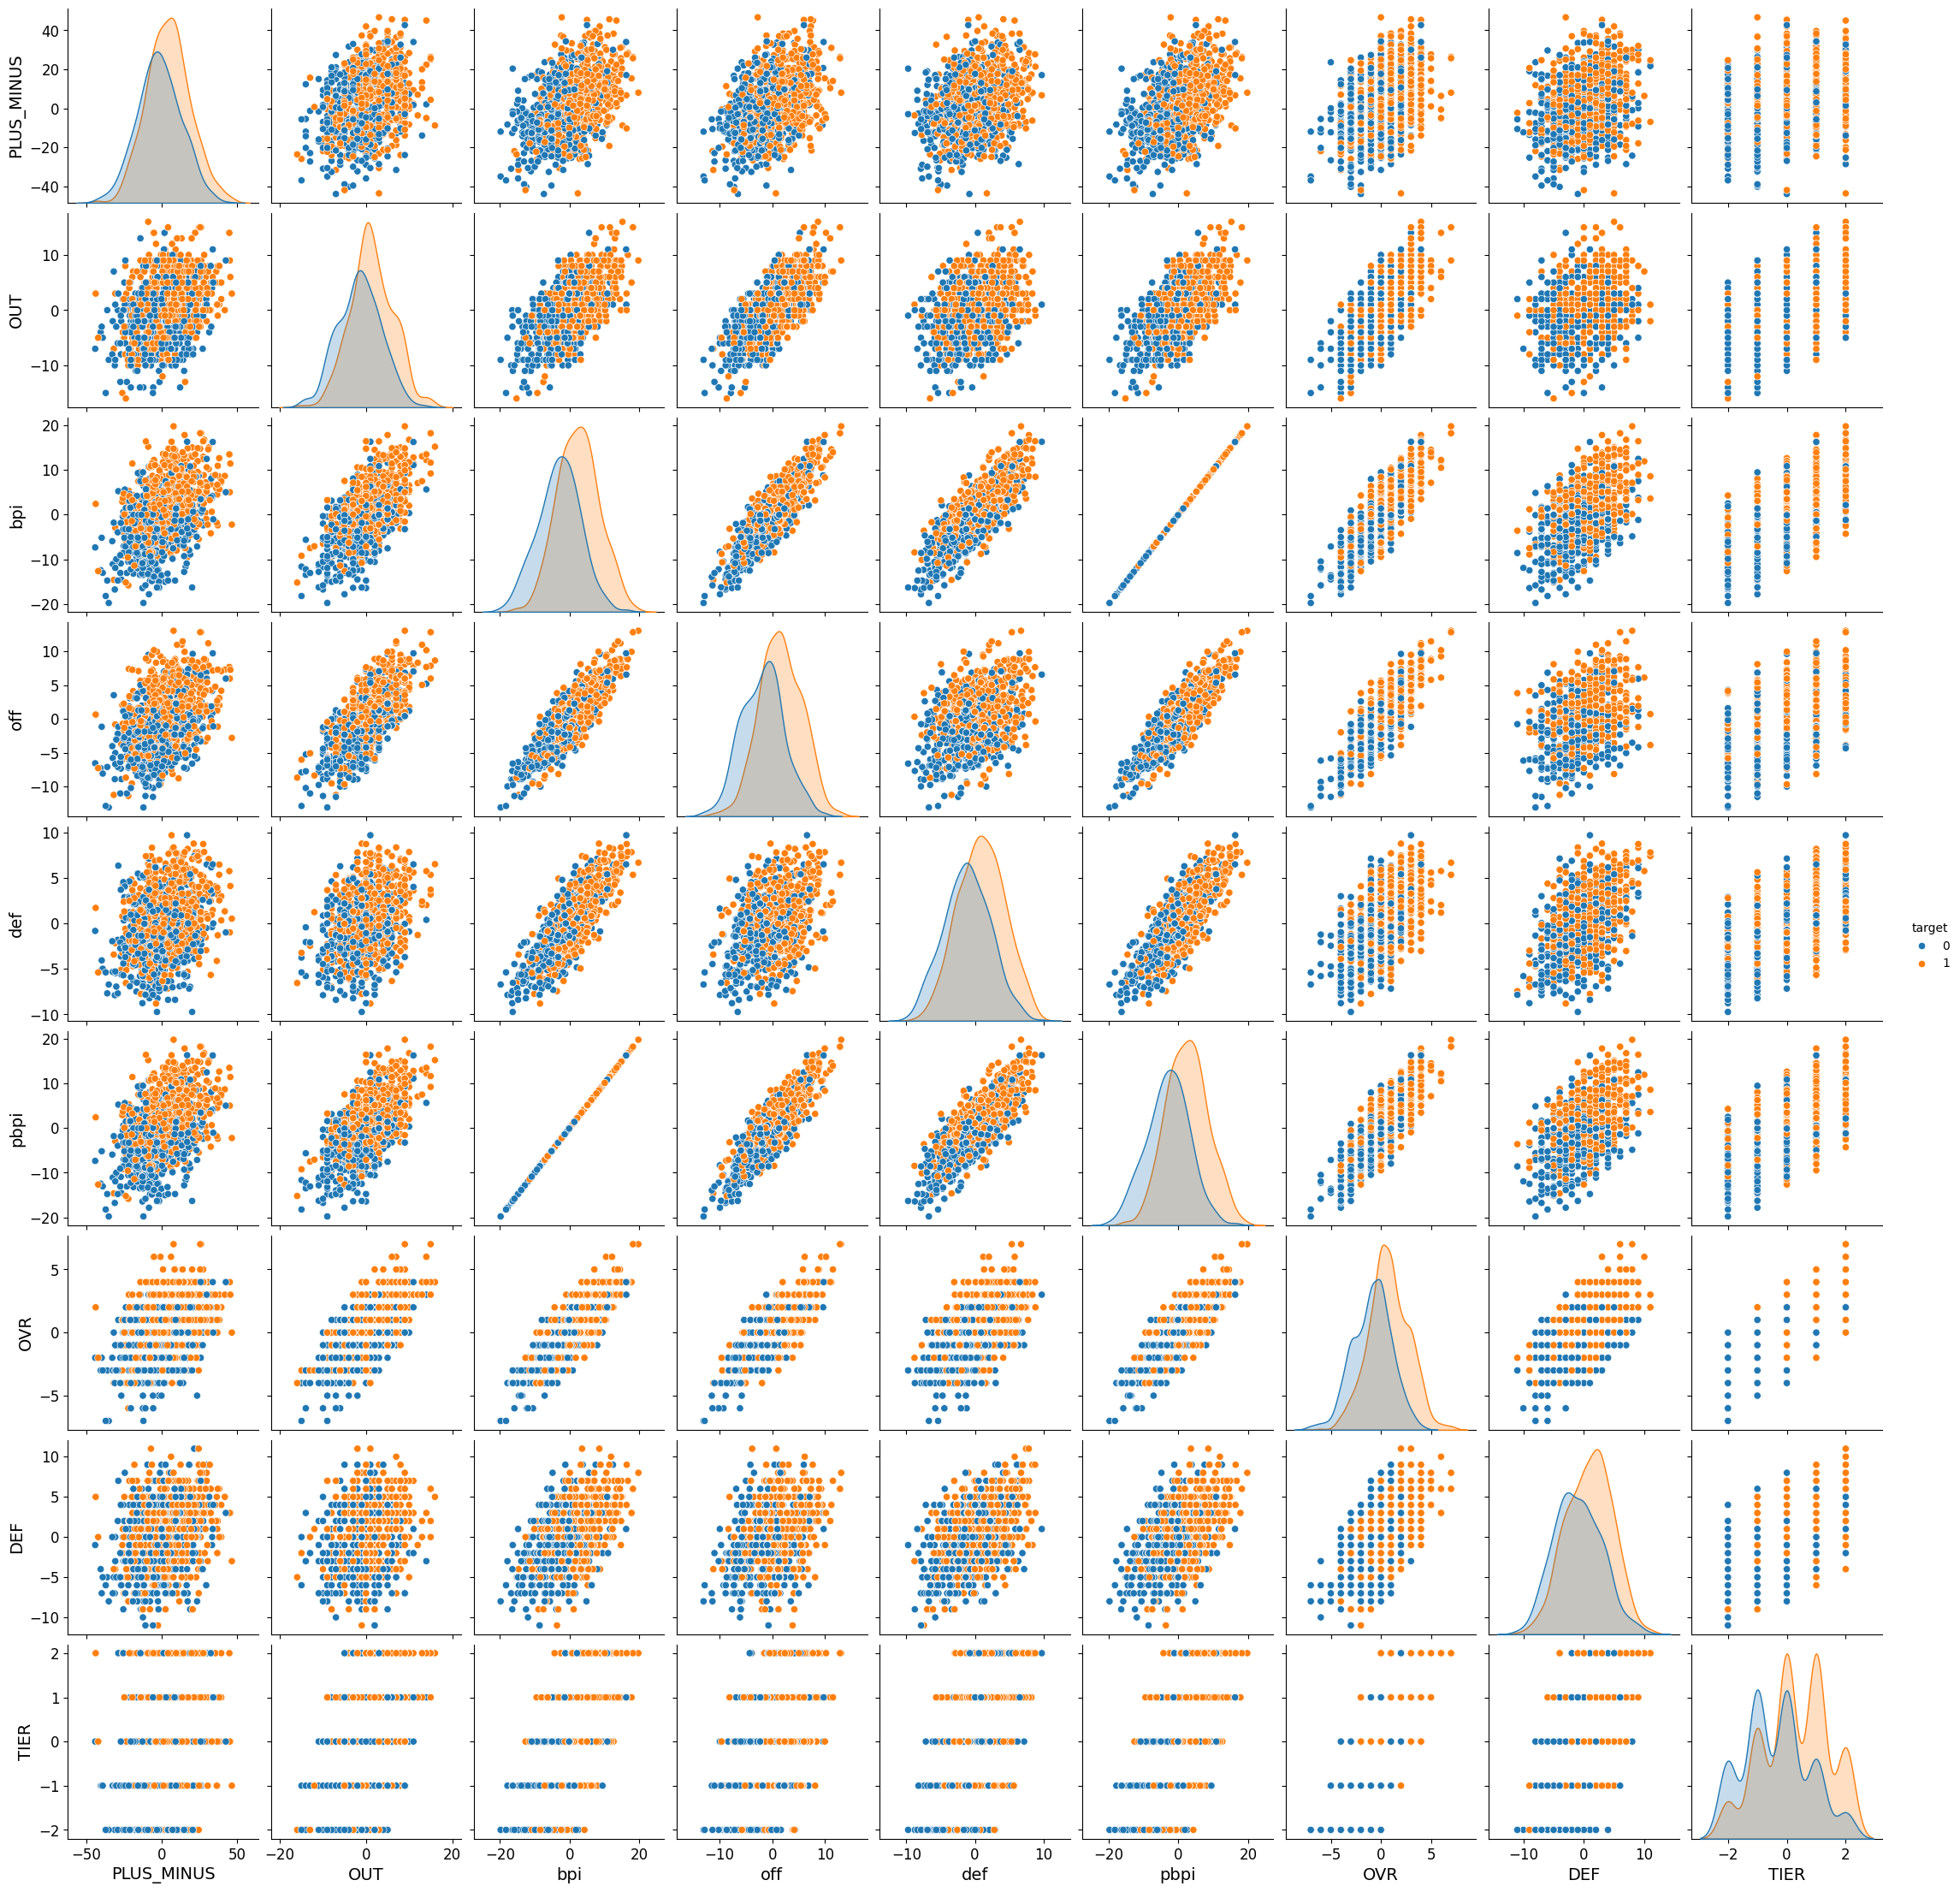

In [42]:
sns.pairplot(df,hue='target')

#### Feature importance estadístico

In [38]:
from sklearn.ensemble import RandomForestClassifier

import numpy as np

names = X.columns
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X, Y)

scores = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True)
pd.DataFrame(scores, columns=['Score', 'Feature'])

,Score,Feature
0,0.2165,PLUS_MINUS
1,0.1538,off
2,0.1510,pbpi
3,0.1319,bpi
4,0.1086,def
5,0.0738,OUT
6,0.0699,DEF
7,0.0570,OVR
8,0.0374,TIER


In [29]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression

print(X.shape)
sel = SelectKBest(f_regression, k=5)
X_new = sel.fit_transform(X, Y)
print(X_new.shape)
print(sel.scores_)

pd.DataFrame({'column': names, 'score': sel.scores_}).sort_values('score', ascending=False)

(1187, 9)
(1187, 5)
[ 50.84089702  94.54705282 241.59610622 209.84002866 112.68152002
 241.59610622 209.41282861  67.90856822 103.54277211]


,column,score
2,bpi,241.596106
5,pbpi,241.596106
3,off,209.840029
6,OVR,209.412829
4,def,112.681520
8,TIER,103.542772
1,OUT,94.547053
7,DEF,67.908568
0,PLUS_MINUS,50.840897


### Random forest

In [63]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
modelo_rf = RandomForestClassifier(n_estimators=300, random_state=42,max_depth=4)
modelo_rf.fit(X_train, y_train)
y_pred= modelo_rf.predict(X_test)



# COMPROBACIÓN DE LAS FEATURE IMPORTANCES
print('-'*50)
print('\n---FEATURE IMPORTANCES---')
features_names = X_train.columns
feature_importances = modelo_rf.feature_importances_
for i in range(len(features_names)):
    if feature_importances[i]>0.001:
        print(features_names[i],round(feature_importances[i],3))
 
#  METRICAS
print('-'*50)
print('\n---MÉTRICAS---')
print('\n---TRAIN---')
y_pred = modelo_rf.predict(X_train)
print("Accuracy score:", round(accuracy_score(y_pred, y_train), 3))
print("Recall score:", round(recall_score(y_pred, y_train), 3))
print("Precision score:", round(precision_score(y_pred, y_train), 3))
print("F1 score:", round(f1_score(y_pred, y_train), 3))
print("AUC:", round(roc_auc_score(y_pred, y_train), 3))
print('\n---TEST---')
y_pred = modelo_rf.predict(X_test)
print("Accuracy score:",round((accuracy_score(y_pred, y_test)),3))
print("Recall score:", round(recall_score(y_pred, y_test), 3))
print("Precision score:", round(precision_score(y_pred, y_test), 3))
print("F1 score:", round(f1_score(y_pred, y_test), 3))
print("AUC:", round(roc_auc_score(y_pred, y_test), 3))

C:\Users\iauzm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


--------------------------------------------------

---FEATURE IMPORTANCES---
PLUS_MINUS 0.063
OUT 0.037
bpi 0.241
off 0.225
def 0.078
pbpi 0.208
OVR 0.088
DEF 0.035
TIER 0.024
--------------------------------------------------

---MÉTRICAS---

---TRAIN---
Accuracy score: 0.722
Recall score: 0.716
Precision score: 0.837
F1 score: 0.772
AUC: 0.725

---TEST---
Accuracy score: 0.706
Recall score: 0.667
Precision score: 0.852
F1 score: 0.748
AUC: 0.724


In [67]:
# Guardar el modelo
import pickle

with open('modelo_rf.model', "wb") as archivo_salida:
    pickle.dump(modelo_rf, archivo_salida)


### XGBOOST

In [68]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
import xgboost as xgb
modelo_xgb = xgb.XGBClassifier(learning_rate=0.1,n_estimators=100,max_depth=2)
modelo_xgb.fit(X_train, y_train)
y_pred= modelo_xgb.predict(X_test)



# COMPROBACIÓN DE LAS FEATURE IMPORTANCES
print('-'*50)
print('\n---FEATURE IMPORTANCES---')
features_names = X_train.columns
feature_importances = modelo_xgb.feature_importances_
for i in range(len(features_names)):
    if feature_importances[i]>0.001:
        print(features_names[i],round(feature_importances[i],3))
 
#  METRICAS
print('-'*50)
print('\n---MÉTRICAS---')
print('\n---TRAIN---')
y_pred = modelo_xgb.predict(X_train)
print("Accuracy score:", accuracy_score(y_pred, y_train))
print("Recall score:", round(recall_score(y_pred, y_train), 3))
print("Precision score:", round(precision_score(y_pred, y_train), 3))
print("F1 score:", round(f1_score(y_pred, y_train), 3))
print("AUC:", round(roc_auc_score(y_pred, y_train), 3))
print('\n---TEST---')
y_pred = modelo_xgb.predict(X_test)
print("Accuracy score:", round((accuracy_score(y_pred, y_test)),3))
print("Recall score:", round(recall_score(y_pred, y_test), 3))
print("Precision score:", round(precision_score(y_pred, y_test), 3))
print("F1 score:", round(f1_score(y_pred, y_test), 3))
print("AUC:", round(roc_auc_score(y_pred, y_test), 3))

--------------------------------------------------

---FEATURE IMPORTANCES---
PLUS_MINUS 0.072
OUT 0.052
bpi 0.26
off 0.233
def 0.084
OVR 0.061
DEF 0.055
TIER 0.184
--------------------------------------------------

---MÉTRICAS---

---TRAIN---
Accuracy score: 0.7239199157007377
Recall score: 0.725
Precision score: 0.82
F1 score: 0.769
AUC: 0.724

---TEST---
Accuracy score: 0.693
Recall score: 0.664
Precision score: 0.811
F1 score: 0.731
AUC: 0.703


In [70]:
# Guardar el modelo
import pickle

with open('modelo_xgb.model', "wb") as archivo_salida:
    pickle.dump(modelo_xgb, archivo_salida)